In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## data preprocessing of the input images and applying both the filters(blur + cdr threshold)

In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
from segmentation_models_pytorch import Unet

# ------------------------
# CONFIGURATION
# ------------------------
MODEL_PATH = "/content/drive/MyDrive/glaucoma_detection/cdr_src/unet_efficientnetb4_drishti.pth"
TEST_ROOT = "/content/drive/MyDrive/glaucoma_detection/test_sets"
OUTPUT_CSV = "/content/drive/MyDrive/glaucoma_detection/test_sets/segmentation_overlays_unet/test_metadata.csv"

RESIZE_DIM = (512, 512)
BLUR_THRESHOLD = 15.0
CDR_LOWER = 0.1
CDR_UPPER = 1.2
CHUNK_SIZE = 25

device = torch.device("cpu")

# ------------------------
# LOAD SMP UNET MODEL
# ------------------------
print("📥 Loading SMP U-Net EfficientNet-B4 on CPU...")

model = Unet(
    encoder_name="efficientnet-b4",
    encoder_weights=None,  # ✅ Must be None to match saved weights
    in_channels=3,
    classes=2
).to(device)

state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("✅ Model loaded successfully")

# ------------------------
# IMAGE TRANSFORMS
# ------------------------
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(RESIZE_DIM),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

def compute_blur_score(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def compute_vertical_extent(mask):
    vertical_indices = np.any(mask, axis=1)
    return np.sum(vertical_indices)

@torch.no_grad()
def compute_cdr(image_np):
    input_tensor = preprocess(image_np).unsqueeze(0).to(device)
    output = model(input_tensor)
    probs = torch.sigmoid(output).squeeze().cpu().numpy()  # [2, H, W]

    disc_mask = probs[0] > 0.5
    cup_mask = probs[1] > 0.5

    disc_vert = compute_vertical_extent(disc_mask)
    cup_vert = compute_vertical_extent(cup_mask)

    if disc_vert == 0:
        return -1

    return cup_vert / disc_vert

# ------------------------
# CHUNKED PROCESSING
# ------------------------
def process_in_chunks(image_list, label, output_df, folder_path):
    for i in range(0, len(image_list), CHUNK_SIZE):
        chunk = image_list[i:i+CHUNK_SIZE]
        chunk_metadata = []

        for img_name in tqdm(chunk, desc=f"Chunk [{i}-{i+len(chunk)}]"):
            img_path = os.path.join(folder_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"⚠️ Skipping unreadable: {img_path}")
                    continue

                img_resized = cv2.resize(img, RESIZE_DIM)
                blur_score = compute_blur_score(img_resized)
                vCDR = compute_cdr(img_resized)

                passed = (
                    blur_score > BLUR_THRESHOLD and
                    CDR_LOWER <= vCDR <= CDR_UPPER
                )

                chunk_metadata.append({
                    "image_path": img_path,
                    "label": label,
                    "vCDR": round(vCDR, 3),
                    "blur_score": round(blur_score, 2),
                    "passed_filtering": passed
                })

            except Exception as e:
                print(f"❌ Error processing {img_name}: {e}")

        chunk_df = pd.DataFrame(chunk_metadata)
        output_df = pd.concat([output_df, chunk_df], ignore_index=True)
        output_df.to_csv(OUTPUT_CSV, index=False)

    return output_df

# ------------------------
# MAIN LOOP OVER FOLDERS
# ------------------------
output_df = pd.DataFrame()

for label_dir in ["GON+", "GON-"]:
    label = 1 if label_dir == "GON+" else 0
    folder_path = os.path.join(TEST_ROOT, label_dir)
    image_list = os.listdir(folder_path)

    print(f"\n🔄 Processing {label_dir} with {len(image_list)} images")
    output_df = process_in_chunks(image_list, label, output_df, folder_path)

print(f"\n✅ All chunks processed. Final metadata saved to: {OUTPUT_CSV}")


📥 Loading SMP U-Net EfficientNet-B4 on CPU...
✅ Model loaded successfully

🔄 Processing GON+ with 32 images


Chunk [25-32]: 100%|██████████| 7/7 [00:11<00:00,  1.70s/it]



🔄 Processing GON- with 360 images


Chunk [0-25]:   8%|▊         | 2/25 [00:02<00:33,  1.44s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0166.jpg


Chunk [0-25]:  16%|█▌        | 4/25 [00:05<00:26,  1.28s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0194.jpg


Chunk [150-175]:  56%|█████▌    | 14/25 [00:21<00:16,  1.49s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0060.jpg


Chunk [150-175]:  64%|██████▍   | 16/25 [00:24<00:11,  1.29s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0136.jpg


Chunk [175-200]:  40%|████      | 10/25 [00:16<00:26,  1.74s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0178.jpg


Chunk [175-200]:  64%|██████▍   | 16/25 [00:24<00:12,  1.44s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0216.jpg


Chunk [175-200]:  80%|████████  | 20/25 [00:29<00:07,  1.41s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0106.jpg


Chunk [350-360]: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


✅ All chunks processed. Final metadata saved to: test_metadata.csv


## segmentation overlays created using unet to pass forward to eomt

In [ ]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from torchvision import transforms
from segmentation_models_pytorch import Unet
from PIL import Image

# ------------------------
# CONFIGURATION
# ------------------------
MODEL_PATH = "/content/drive/MyDrive/glaucoma_detection/cdr_src/unet_efficientnetb4_drishti.pth"
TEST_ROOT = "/content/drive/MyDrive/glaucoma_detection/test_sets"
OUTPUT_ROOT = "/content/drive/MyDrive/glaucoma_detection/test_sets/segmentation_overlays_unet"
RESIZE_DIM = (512, 512)

device = torch.device("cpu")

# ------------------------
# LOAD SMP UNET MODEL
# ------------------------
model = Unet(
    encoder_name="efficientnet-b4",
    encoder_weights=None,
    in_channels=3,
    classes=2
).to(device)

state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

# ------------------------
# TRANSFORMS
# ------------------------
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(RESIZE_DIM),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

@torch.no_grad()
def predict_masks(img_np):
    input_tensor = preprocess(img_np).unsqueeze(0).to(device)
    output = model(input_tensor)
    probs = torch.sigmoid(output).squeeze().cpu().numpy()  # [2, H, W]

    disc_mask = (probs[0] > 0.5).astype(np.uint8)
    cup_mask  = (probs[1] > 0.5).astype(np.uint8)
    return disc_mask, cup_mask

def overlay_masks(original_img, disc_mask, cup_mask, alpha=0.4):
    overlay = original_img.copy()
    h, w, _ = overlay.shape

    # Resize masks to original image size
    disc_mask_resized = cv2.resize(disc_mask, (w, h), interpolation=cv2.INTER_NEAREST)
    cup_mask_resized = cv2.resize(cup_mask, (w, h), interpolation=cv2.INTER_NEAREST)

    # Color overlay
    overlay[cup_mask_resized == 1] = [0, 0, 255]    # Red for cup
    overlay[disc_mask_resized == 1] = [0, 255, 0]   # Green for disc

    # Blend with original
    blended = cv2.addWeighted(original_img, 1 - alpha, overlay, alpha, 0)
    return blended

# ------------------------
# MAIN LOOP
# ------------------------
for label_dir in ["GON+", "GON-"]:
    folder_path = os.path.join(TEST_ROOT, label_dir)
    save_path = os.path.join(OUTPUT_ROOT, label_dir)
    os.makedirs(save_path, exist_ok=True)

    for img_name in tqdm(os.listdir(folder_path), desc=f"Overlaying {label_dir}"):
        try:
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠️ Skipping unreadable: {img_path}")
                continue

            img_resized = cv2.resize(img, RESIZE_DIM)
            disc_mask, cup_mask = predict_masks(img_resized)

            overlay = overlay_masks(img_resized, disc_mask, cup_mask)

            # Save
            save_file = os.path.join(save_path, img_name.replace(".jpg", "_overlay.png").replace(".jpeg", "_overlay.png").replace(".png", "_overlay.png"))
            cv2.imwrite(save_file, overlay)

        except Exception as e:
            print(f"❌ Error on {img_name}: {e}")


Overlaying GON-:   1%|          | 2/360 [00:03<09:24,  1.58s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0166.jpg


Overlaying GON-:   1%|          | 4/360 [00:06<09:27,  1.59s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0194.jpg


Overlaying GON-:  46%|████▌     | 164/360 [04:26<05:06,  1.56s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0060.jpg


Overlaying GON-:  46%|████▌     | 166/360 [04:27<03:50,  1.19s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0136.jpg


Overlaying GON-:  51%|█████▏    | 185/360 [04:56<04:28,  1.53s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0178.jpg


Overlaying GON-:  53%|█████▎    | 191/360 [05:05<04:22,  1.55s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0216.jpg


Overlaying GON-:  54%|█████▍    | 195/360 [05:09<03:39,  1.33s/it]

⚠️ Skipping unreadable: /content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0106.jpg


Overlaying GON-: 100%|██████████| 360/360 [09:41<00:00,  1.61s/it]


In [3]:
%%capture
!pip install --upgrade git+https://github.com/huggingface/transformers
!pip install pillow matplotlib segmentation-models-pytorch


In [4]:
from transformers import AutoImageProcessor, EomtForUniversalSegmentation

processor = AutoImageProcessor.from_pretrained("tue-mps/ade20k_semantic_eomt_large_512")
model = EomtForUniversalSegmentation.from_pretrained("tue-mps/ade20k_semantic_eomt_large_512")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

## EOMT classification and segmentation overlays

In [5]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
from segmentation_models_pytorch import Unet
from transformers import EomtForUniversalSegmentation
import torch.nn as nn
from PIL import Image

# -------------------------------
# CONFIGURATION
# -------------------------------
UNET_PATH = "/content/drive/MyDrive/glaucoma_detection/cdr_src/unet_efficientnetb4_drishti.pth"
CHECKPOINT_PATH = "/content/drive/MyDrive/glaucoma_detection/eomt/best_eomt.pth"
TEST_ROOT = "/content/drive/MyDrive/glaucoma_detection/test_sets"
OUT_CSV = "/content/drive/MyDrive/glaucoma_detection/test_sets/eomt_predictions.csv"
VISUAL_DIR = "/content/drive/MyDrive/glaucoma_detection/test_sets/eomt_visuals"

device = torch.device("cpu")
RESIZE_DIM = (512, 512)

# -------------------------------
# LOAD MODELS
# -------------------------------
print("📅 Loading U-Net EfficientNet-B4 on CPU...")
unet = Unet(
    encoder_name="efficientnet-b4",
    encoder_weights=None,
    in_channels=3,
    classes=2
).to(device)
unet.load_state_dict(torch.load(UNET_PATH, map_location=device))
unet.eval()

print("📅 Loading EOMT and classifier head...")
eomt = EomtForUniversalSegmentation.from_pretrained("tue-mps/ade20k_semantic_eomt_large_512").to(device)

class ClassifierHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        return self.fc(x)

classifier_head = ClassifierHead().to(device)

ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
eomt.load_state_dict(ckpt['model_state_dict'])
classifier_head.load_state_dict(ckpt['classifier_state_dict'])
eomt.eval()
classifier_head.eval()

normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

# -------------------------------
# OD/OC Prediction Function
# -------------------------------
@torch.no_grad()
def predict_od_oc(img_np):
    tensor = transforms.ToTensor()(cv2.resize(img_np, RESIZE_DIM)).unsqueeze(0).to(device)
    tensor = normalize(tensor[0]).unsqueeze(0)
    output = unet(tensor)
    probs = torch.sigmoid(output).squeeze().cpu().numpy()
    return probs[0] > 0.5, probs[1] > 0.5  # disc, cup

# -------------------------------
# EOMT Classification Function
# -------------------------------
@torch.no_grad()
def classify_eomt(fundus_rgb):
    fundus_rgb = cv2.resize(fundus_rgb, RESIZE_DIM)
    fundus_tensor = transforms.ToTensor()(fundus_rgb)
    fundus_tensor = normalize(fundus_tensor).unsqueeze(0).to(device)
    outputs = eomt(pixel_values=fundus_tensor, output_hidden_states=True)
    features = outputs.hidden_states[-1].mean(dim=1)
    logits = classifier_head(features)
    probs = torch.softmax(logits, dim=1).squeeze().cpu().numpy()
    pred = int(np.argmax(probs))
    return pred, probs[1]  # pred, probability of GON+

# -------------------------------
# Overlay Visualization Function
# -------------------------------
def overlay_masks(image, disc_mask, cup_mask, label):
    overlay = image.copy()
    disc_mask = cv2.resize(disc_mask.astype(np.uint8), image.shape[:2][::-1])
    cup_mask = cv2.resize(cup_mask.astype(np.uint8), image.shape[:2][::-1])
    overlay[cup_mask == 1] = [0, 0, 255]    # Red = cup
    overlay[disc_mask == 1] = [0, 255, 0]   # Green = disc
    return cv2.putText(overlay, f"GON: {'+' if label else '-'}", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)

# -------------------------------
# Inference Loop
# -------------------------------
results = []

for label_dir in ["GON+", "GON-"]:
    label_folder = os.path.join(TEST_ROOT, label_dir)
    out_folder = os.path.join(VISUAL_DIR, label_dir)
    os.makedirs(out_folder, exist_ok=True)
    true_label = 1 if label_dir == "GON+" else 0

    for fname in tqdm(os.listdir(label_folder), desc=f"Classifying {label_dir}"):
        try:
            img_path = os.path.join(label_folder, fname)
            fundus = cv2.imread(img_path)
            if fundus is None:
                print(f"⚠️ Could not read: {img_path}")
                continue

            disc_mask, cup_mask = predict_od_oc(fundus)
            pred_label, pred_prob = classify_eomt(fundus)

            results.append({
                "image_path": img_path,
                "true_label": true_label,
                "predicted_label": pred_label,
                "predicted_probability": pred_prob
            })

            vis = overlay_masks(cv2.resize(fundus, RESIZE_DIM), disc_mask, cup_mask, pred_label)
            out_path = os.path.join(out_folder, fname.replace(".jpg", "_eomt.png"))
            cv2.imwrite(out_path, vis)

        except Exception as e:
            print(f"❌ Error on {fname}: {e}")

# -------------------------------
# Save Results CSV
# -------------------------------
df = pd.DataFrame(results)
df.to_csv(OUT_CSV, index=False, encoding='utf-8')
print(f"✅ Saved predictions to: {OUT_CSV}")


📅 Loading U-Net EfficientNet-B4 on CPU...
📅 Loading EOMT and classifier head...


Classifying GON+:  10%|▉         | 40/417 [11:16<1:46:12, 16.90s/it]


KeyboardInterrupt: 

In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from torchvision import transforms
from segmentation_models_pytorch import Unet
from transformers import EomtForUniversalSegmentation
import torch.nn as nn
from PIL import Image

# -------------------------------
# CONFIGURATION
# -------------------------------
UNET_PATH = "/content/drive/MyDrive/glaucoma_detection/cdr_src/unet_efficientnetb4_drishti.pth"
CHECKPOINT_PATH = "/content/drive/MyDrive/glaucoma_detection/eomt/best_eomt.pth"
TEST_ROOT = "/content/drive/MyDrive/glaucoma_detection/test_sets"
OUT_CSV = "/content/drive/MyDrive/glaucoma_detection/test_sets/eomt_predictions.csv"
VISUAL_DIR = "/content/drive/MyDrive/glaucoma_detection/test_sets/eomt_visuals"

device = torch.device("cpu")
RESIZE_DIM = (512, 512)

# -------------------------------
# LOAD MODELS
# -------------------------------
print("📅 Loading U-Net EfficientNet-B4 on CPU...")
unet = Unet(
    encoder_name="efficientnet-b4",
    encoder_weights=None,
    in_channels=3,
    classes=2
).to(device)
unet.load_state_dict(torch.load(UNET_PATH, map_location=device))
unet.eval()

print("📅 Loading EOMT and classifier head...")
eomt = EomtForUniversalSegmentation.from_pretrained("tue-mps/ade20k_semantic_eomt_large_512").to(device)

class ClassifierHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        return self.fc(x)

classifier_head = ClassifierHead().to(device)

ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
eomt.load_state_dict(ckpt['model_state_dict'])
classifier_head.load_state_dict(ckpt['classifier_state_dict'])
eomt.eval()
classifier_head.eval()

normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

# -------------------------------
# OD/OC Prediction Function
# -------------------------------
@torch.no_grad()
def predict_od_oc(img_np):
    tensor = transforms.ToTensor()(cv2.resize(img_np, RESIZE_DIM)).unsqueeze(0).to(device)
    tensor = normalize(tensor[0]).unsqueeze(0)
    output = unet(tensor)
    probs = torch.sigmoid(output).squeeze().cpu().numpy()
    return probs[0] > 0.5, probs[1] > 0.5  # disc, cup

# -------------------------------
# EOMT Classification Function
# -------------------------------
@torch.no_grad()
def classify_eomt(fundus_rgb):
    fundus_rgb = cv2.resize(fundus_rgb, RESIZE_DIM)
    fundus_tensor = transforms.ToTensor()(fundus_rgb)
    fundus_tensor = normalize(fundus_tensor).unsqueeze(0).to(device)
    outputs = eomt(pixel_values=fundus_tensor, output_hidden_states=True)
    features = outputs.hidden_states[-1].mean(dim=1)
    logits = classifier_head(features)
    pred = torch.argmax(logits, dim=1).item()
    return pred

# -------------------------------
# Overlay Visualization Function
# -------------------------------
def overlay_masks(image, disc_mask, cup_mask, label):
    overlay = image.copy()
    disc_mask = cv2.resize(disc_mask.astype(np.uint8), image.shape[:2][::-1])
    cup_mask = cv2.resize(cup_mask.astype(np.uint8), image.shape[:2][::-1])
    overlay[cup_mask == 1] = [0, 0, 255]    # Red = cup
    overlay[disc_mask == 1] = [0, 255, 0]   # Green = disc
    return cv2.putText(overlay, f"GON: {'+' if label else '-'}", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)

# -------------------------------
# Load Results and Compute Metrics
# -------------------------------
df = pd.read_csv(OUT_CSV)
y_true = df['true_label']
y_pred = df['predicted_label']

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["GON-", "GON+"]))

print("\n🧮 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

try:
    print("\n📈 ROC-AUC Score:")
    print(roc_auc_score(y_true, y_pred))
except:
    print("ROC-AUC Score could not be computed (requires binary probabilities or continuous scores).")


📅 Loading U-Net EfficientNet-B4 on CPU...
📅 Loading EOMT and classifier head...

📊 Classification Report:
              precision    recall  f1-score   support

        GON-       0.92      0.22      0.35       353
        GON+       0.08      0.78      0.15        32

    accuracy                           0.26       385
   macro avg       0.50      0.50      0.25       385
weighted avg       0.85      0.26      0.33       385


🧮 Confusion Matrix:
[[ 76 277]
 [  7  25]]

📈 ROC-AUC Score:
0.4982737252124646


## Dinov2 classification using soft fusion within the four classifiers

In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
import torch.nn as nn

# --------------------------------
# CONFIG
# --------------------------------
DINO_MODEL_PATHS = {
    "drishti": "/content/drive/MyDrive/glaucoma_detection/dinov2_classifiers/best_dinov2_classifier_drishti_augmented.pth",
    "refuge": "/content/drive/MyDrive/glaucoma_detection/dinov2_classifiers/best_dinov2_classifier_refuge_only.pth",
    "eyepacs-airogsv2":   "/content/drive/MyDrive/glaucoma_detection/dinov2_classifiers/best_dinov2_classifier_airogs.pth",
    "hygd":    "/content/drive/MyDrive/glaucoma_detection/dinov2_classifiers/best_dinov2_classifier_hygd.pth",
}
TEST_ROOT = "/content/drive/MyDrive/glaucoma_detection/test_sets"
DINO_CSV = "/content/drive/MyDrive/glaucoma_detection/test_sets/dinov2_predictions.csv"

device = torch.device("cpu")
RESIZE_DIM = (518, 518)  # must be divisible by 14 for ViT-S/14
NUM_CLASSES = 2

# --------------------------------
# Load DINOv2 Backbone
# --------------------------------
dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)
dinov2.eval()

# Normalize
normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

# --------------------------------
# Classifier Head Definition
# --------------------------------
class ClassifierHead(nn.Module):
    def __init__(self, in_dim=384, num_classes=2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_dim, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# --------------------------------
# Load all DINOv2 classifiers
# --------------------------------
dino_heads = []
for _, path in DINO_MODEL_PATHS.items():
    clf = ClassifierHead().to(device)
    state = torch.load(path, map_location=device)
    clf.load_state_dict(state['classifier_state_dict'])
    clf.eval()
    dino_heads.append(clf)

# --------------------------------
# DINOv2 Soft-Fused Prediction Function
# --------------------------------
@torch.no_grad()
def classify_dino(fundus_rgb):
    fundus_rgb = cv2.resize(fundus_rgb, RESIZE_DIM)
    tensor = transforms.ToTensor()(fundus_rgb)
    tensor = normalize(tensor).unsqueeze(0).to(device)

    features = dinov2(tensor).squeeze()
    logits_sum = torch.zeros(NUM_CLASSES).to(device)

    for clf in dino_heads:
        logits = clf(features.unsqueeze(0))
        probs = torch.softmax(logits, dim=1).squeeze()
        logits_sum += probs

    final_probs = logits_sum / len(dino_heads)
    pred = int(torch.argmax(final_probs))
    return pred, final_probs[1].item()  # prediction, GON+ probability

# --------------------------------
# Inference Loop
# --------------------------------
results = []

for label_dir in ["GON+", "GON-"]:
    label_folder = os.path.join(TEST_ROOT, label_dir)
    true_label = 1 if label_dir == "GON+" else 0

    for fname in tqdm(os.listdir(label_folder), desc=f"Classifying {label_dir}"):
        try:
            img_path = os.path.join(label_folder, fname)
            fundus = cv2.imread(img_path)
            if fundus is None:
                print(f"⚠️ Could not read: {img_path}")
                continue

            pred_label, prob = classify_dino(fundus)

            results.append({
                "image_path": img_path,
                "true_label": true_label,
                "predicted_label": pred_label,
                "predicted_probability": prob
            })

        except Exception as e:
            print(f"❌ Error on {fname}: {e}")

# --------------------------------
# Save Results CSV
# --------------------------------
df = pd.DataFrame(results)
df.to_csv(DINO_CSV, index=False, encoding='utf-8')
print(f"✅ Saved predictions to: {DINO_CSV}")


📅 Loading U-Net EfficientNet-B4 on CPU...
📅 Loading EOMT and classifier head...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Classifying GON+:   0%|          | 0/417 [00:14<?, ?it/s]


KeyboardInterrupt: 

## DYNAMIC FUSION FOR FINAL PREDICTION USING PROBABLITIES FROM eomt AND dino

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
INPUT_CSV = "/content/drive/MyDrive/glaucoma_detection/test_sets/probability_preds_combined.csv"
FUSED_CSV = "/content/drive/MyDrive/glaucoma_detection/test_sets/final_dynamic_fusion_predictions.csv"
BENCHMARK_PLOT = "/content/drive/MyDrive/glaucoma_detection/glaucfusion_dynamic_fusion_benchmark.png"

# === Load prediction probabilities ===
df = pd.read_csv(INPUT_CSV)

# Columns must include:
# 'image', 'true_label', 'eomt_prob_GON+', 'dino_prob_GON+'
assert all(col in df.columns for col in ['eomt_prob_GON+', 'dino_prob_GON+', 'true_label'])

# === Dynamic Weighting Function ===
def dynamic_fusion(p_eomt, p_dino, alpha=1.5):
    """
    Fuse EoMT and DINOv2 predictions dynamically using confidence.
    Higher confidence gets higher weight dynamically.
    alpha: controls sharpness of weighting.
    """
    conf_eomt = abs(p_eomt - 0.5)
    conf_dino = abs(p_dino - 0.5)

    # Normalize confidences
    w_eomt = conf_eomt ** alpha
    w_dino = conf_dino ** alpha
    total = w_eomt + w_dino

    if total == 0:  # Avoid divide-by-zero
        return 0.5
    return (w_eomt * p_eomt + w_dino * p_dino) / total

# === Apply Dynamic Fusion ===
df['final_prob_GON+'] = df.apply(lambda row: dynamic_fusion(row['eomt_prob_GON+'], row['dino_prob_GON+']), axis=1)
df['final_pred'] = (df['final_prob_GON+'] >= 0.5).astype(int)

# === Save Final Predictions ===
df[['image', 'true_label', 'final_pred', 'final_prob_GON+']].to_csv(FUSED_CSV, index=False)
print(f"✅ Saved final dynamic fusion predictions to: {FUSED_CSV}")

# === Evaluate Performance ===
y_true = df['true_label']
y_pred = df['final_pred']
y_score = df['final_prob_GON+']

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['GON-', 'GON+']))

print("\n🧮 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\n📈 ROC-AUC Score:")
print(roc_auc_score(y_true, y_score))

# === Benchmark Barplot ===
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1-score": f1_score(y_true, y_pred)
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='coolwarm')
plt.ylim(0, 1)
plt.title("📊 Performance Metrics - GlaucFusion (Dynamic Fusion)")
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(BENCHMARK_PLOT)
plt.show()


## dataset class prediction using finetuned resnet-18

Classifying dataset source for GON-:   1%|          | 3/360 [00:01<02:27,  2.42it/s]

❌ Error on n0166.jpg: cannot identify image file '/content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0166.jpg'


Classifying dataset source for GON-:   1%|          | 4/360 [00:04<09:01,  1.52s/it]

❌ Error on n0194.jpg: cannot identify image file '/content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0194.jpg'


Classifying dataset source for GON-:  46%|████▌     | 166/360 [00:38<00:30,  6.31it/s]

❌ Error on n0060.jpg: cannot identify image file '/content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0060.jpg'
❌ Error on n0136.jpg: cannot identify image file '/content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0136.jpg'


Classifying dataset source for GON-:  52%|█████▏    | 187/360 [00:42<00:22,  7.54it/s]

❌ Error on n0178.jpg: cannot identify image file '/content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0178.jpg'


Classifying dataset source for GON-:  54%|█████▎    | 193/360 [00:43<00:21,  7.82it/s]

❌ Error on n0216.jpg: cannot identify image file '/content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0216.jpg'


Classifying dataset source for GON-:  55%|█████▍    | 197/360 [00:43<00:19,  8.30it/s]

❌ Error on n0106.jpg: cannot identify image file '/content/drive/MyDrive/glaucoma_detection/test_sets/GON-/n0106.jpg'


Classifying dataset source for GON+: 100%|██████████| 417/417 [00:58<00:00,  7.09it/s]


✅ Saved dataset classification results to: /content/drive/MyDrive/glaucoma_detection/test_sets/resnet18_dataset_predictions.csv


/tmp/ipython-input-13-370851755.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="predicted_dataset", order=DATASET_CLASSES, palette="Spectral")
/tmp/ipython-input-13-370851755.py:84: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-13-370851755.py:85: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(DIST_PLOT_PATH)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


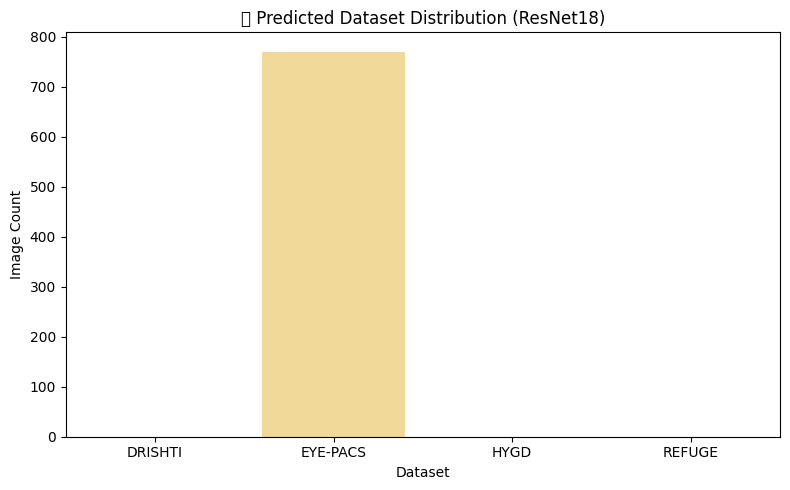

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
RESNET18_MODEL_PATH = "/content/drive/MyDrive/glaucoma_detection/resnet18_classifier/dataset_classifier_resnet18.pth"
TEST_ROOT = "/content/drive/MyDrive/glaucoma_detection/test_sets"
OUT_CSV = "/content/drive/MyDrive/glaucoma_detection/test_sets/resnet18_dataset_predictions.csv"
DIST_PLOT_PATH = "/content/drive/MyDrive/glaucoma_detection/resnet18_dataset_distribution.png"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_CLASSES = ["DRISHTI", "EYE-PACS", "HYGD", "REFUGE"]  # Make sure order matches training

# --- DEFINE MODEL ---
class DatasetClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(DatasetClassifier, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# --- LOAD MODEL ---
model = DatasetClassifier(num_classes=4).to(DEVICE)
model.load_state_dict(torch.load(RESNET18_MODEL_PATH, map_location=DEVICE))
model.eval()

# --- TRANSFORM ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# --- PREDICTION FUNCTION ---
@torch.no_grad()
def predict_dataset_class(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)
    logits = model(img_tensor)
    pred_idx = torch.argmax(logits, dim=1).item()
    confidence = torch.softmax(logits, dim=1).squeeze()[pred_idx].item()
    return DATASET_CLASSES[pred_idx], confidence

# --- INFERENCE LOOP ---
results = []
for label_folder in ["GON-", "GON+"]:
    folder_path = os.path.join(TEST_ROOT, label_folder)
    for fname in tqdm(os.listdir(folder_path), desc=f"Classifying dataset source for {label_folder}"):
        img_path = os.path.join(folder_path, fname)
        try:
            pred_class, conf = predict_dataset_class(img_path)
            results.append({
                "image": fname,
                "image_path": img_path,
                "true_label": 1 if label_folder == "GON+" else 0,
                "predicted_dataset": pred_class,
                "confidence": round(conf, 4)
            })
        except Exception as e:
            print(f"❌ Error on {fname}: {e}")

# --- SAVE RESULTS ---
df = pd.DataFrame(results)
df.to_csv(OUT_CSV, index=False)
print(f"✅ Saved dataset classification results to: {OUT_CSV}")

# --- VISUALIZATION ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="predicted_dataset", order=DATASET_CLASSES, palette="Spectral")
plt.title("📊 Predicted Dataset Distribution (ResNet18)")
plt.xlabel("Dataset")
plt.ylabel("Image Count")
plt.tight_layout()
plt.savefig(DIST_PLOT_PATH)
plt.show()


## final output with all meaningfull information

In [ ]:
import pandas as pd

# --- Paths ---
fusion_csv = "/content/drive/MyDrive/glaucoma_detection/test_sets/final_predictions_softfusion.csv"
dataset_csv = "/content/drive/MyDrive/glaucoma_detection/test_sets/resnet18_dataset_predictions.csv"
out_csv = "/content/drive/MyDrive/glaucoma_detection/test_sets/final_predictions_softfusion_with_dataset.csv"

# --- Load both CSVs ---
df_fusion = pd.read_csv(fusion_csv)
df_dataset = pd.read_csv(dataset_csv)

# --- Merge on image filename ---
df_merged = pd.merge(df_fusion, df_dataset, on="image", how="left")

# --- Save ---
df_merged.to_csv(out_csv, index=False)

print(f"✅ Saved merged CSV with dataset source to:\n{out_csv}")
print(df_merged.head())


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load merged CSV ---
csv_path = "/content/drive/MyDrive/glaucoma_detection/test_sets/final_predictions_softfusion_with_dataset.csv"
df = pd.read_csv(csv_path)

# --- Prepare metric containers ---
dataset_metrics = []

# --- Evaluate per predicted dataset ---
for ds in df['predicted_dataset'].unique():
    subset = df[df['predicted_dataset'] == ds]
    y_true = subset['true_label']
    y_pred = subset['predicted_label']

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    try:
        roc = roc_auc_score(y_true, y_pred)
    except:
        roc = None

    dataset_metrics.append({
        "Dataset": ds,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "ROC-AUC": roc
    })

# --- Create DataFrame ---
metrics_df = pd.DataFrame(dataset_metrics)
print("📊 Stratified Metrics per Dataset:")
print(metrics_df)

# --- Save to CSV (optional) ---
metrics_df.to_csv("/content/drive/MyDrive/glaucoma_detection/test_sets/stratified_metrics.csv", index=False)

# --- Plot ---
plt.figure(figsize=(12, 6))
metrics_melted = metrics_df.melt(id_vars="Dataset", value_vars=["Accuracy", "Precision", "Recall", "F1-score"])
sns.barplot(data=metrics_melted, x="Dataset", y="value", hue="variable")
plt.ylim(0, 1)
plt.title("📈 Per-Dataset GON Prediction Metrics")
plt.ylabel("Score")
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/glaucoma_detection/stratified_metrics_plot.png")
plt.show()
